# Radiative forcing calculation

In [1]:
import pandas as pd
import numpy as np
import glob
import scipy.stats
import gmpy2
from gmpy2 import mpfr

In [11]:
# Constants

# Ketura PV field electricity production
daily_average = mpfr (25423.11, 120)               # kWh day -1, total daily average electricity production, data from company
daily_rounded = mpfr (25500.00, 120)               # kWh day-1, rounding the above value
area_pv_ketura = mpfr (75600, 120)                 # m2, area of the PV field in Ketura
PVe_m2 = daily_rounded/area_pv_ketura              # kWh m-2 day-1, the daily electricity output of the Ketura field divided by the total area
EP_a = PVe_m2 * 365                                # kWh m-2 year-1, Electricity Production annual (daily_rounded/area_pv_ketura) * 365, gives the annual electricity production of the field per m2, equation 2.8 of my thesis

# Life-cycle assessment of PV
LCA = 0.039                                        # kgCO2eq kWh-1, amount of CO2eq emitted by the production, transport, operation, disposal and recycling of the PV panels (Meier and Kulcinski, 2002)
LCA_storage = 0.095                                # kgCO2eq kWh-1, amount of CO2eq emitted PV electricity production considering all the steps above + all the steps of storage (Lima, 2021)

# Storage Performance Ratio
PR_storage = 0.8                                   # 0.6-0.95, depending on the storage techbology (Lima, 2021)

# Amount of CO2 emitted by each kWh generated by different sources (International Energy Agency, 2019)
FCO2_coal = 0.87                                   # Coal [kgCO2 kWh-1] (International Energy Agency, 2019, Page I.21)
FCO2_gas = 0.40                                    # Gas [kgCO2 kWh-1] (International Energy Agency, 2019, Page I.21)
FCO2_world = 0.54                                  # World [kgCO2 kWh-1] (International Energy Agency, 2019, Page II.67)

# Afforestation
C_afforestation =  0.15                            # Carbon sequestration [kg carbon m-2 year-1] (Qubaja, 2020)

Eg = 245                                           # Insolation [W m^-2], IMS
albedo_yatir_forest = 0.12                         # unitless - Shani
albedo_yatir_desert = 0.27                         # unitless - Shani
albedo_ketura_pv = 0.24                            # unitless - Shani
albedo_ketura_desert = 0.40                        # unitless - Shani
delta_alb_yatir = albedo_yatir_desert - albedo_yatir_forest
delta_alb_ketura = albedo_ketura_desert - albedo_ketura_pv
PVeff = 0.058                                        # unitless, is the ratio between PVe_annual and the mean annual solar irradiation of the region (2122 kWh m-2, Vardimon 2011)

#g = 0.0010368                                     # conversion from [umol m^-2 s^-1] to [kgC m^-2 d^-1]
#fgc = 0.0216                                      # conversion from [umol m^-2 s^-1] to [gC m^-2 30min^-1]

In [12]:
print (EP_a)

123.11507936507936507936507936507936501


### Functions

In [13]:
# (1) Radiative forcing
# - - - - - - - - - - -

def list_to_float(lst):
    out_lst = [float(i) for i in lst]
    return(out_lst)

# Carbon Emission Suppression: The amount of C which would be emitted annualy to the atmosphere
# if the same amount of energy would be produced by an FCO2 source (coal, gase, world mixture). Requires:
# - Annual electricity Production (kWh m-2 year-1)
# - Amount of CO2 emitted by the production, transport, operation, disposal and recycling of the PV panels (Meier and Kulcinski, 2022) 
def calculate_CES(EP_a, FCO2, LCA):
    CO2_to_C = 0.272727273 # Conversion factor, 12/44 g mol-1 (molar mass of C/CO2)
    # Calculate CES
    CES = EP_a * (FCO2 - LCA) * CO2_to_C # kgC m-2 year-1
    return(CES)

# Equation 1
# I have to apply the transmitance factor to the product (delta albedo * Eg), because the Sn is
# Sn = SWin_desert - SWin_pvfield - SWout_desert - SWout_pvfield, and SWin is equal in both
# desert and pv field. Therefore, Sn is only SWout_desert - SWout_pvfield, and transmitance factor
# applies to SWout only (because SWin already passed thgough the atmosphere, and regarding 
# global warming, we need to do the calculations at the toa). (delta albedo * Eg) is equivalent
# to SWout, and that`s why I need to apply the transmittance factor.

def calculate_breakeven_time_etminan(delta_albedo, pveff, insolation, CES, RF_t=0):
    # Set calculation precision
    gmpy2.get_context().precision=120
    # Constants
    Area_earth = mpfr('5.1e14',120)     # Surface area of planet Earth [m^2]
    k = mpfr('2.16e12',120)             # [kgC ppm^-1] (Nemet)
    af = 0.46                           # airborne fraction (Friedlingstein 2020, Global Carbon Project)
    C0_ppm = mpfr('409.85',120)         # base background CO2 [ppm] in 2019 https://www.esrl.noaa.gov/gmd/ccgg/trends/gl_data.html
    N2O = 331                           # base background N2O [ppb] in 2019 https://www.esrl.noaa.gov/gmd/ccgg/trends_n2o/
    
    # Radiative forcing of the albedo change
    RFr_global = (delta_albedo * insolation + 0.1*RF_t)/Area_earth
    RFr_local  = (delta_albedo - pveff) * insolation + 0.1*RF_t
    
    # Radiative forcing of carbon emission suppression OR sequestration
    delta_C  = CES*af/k
    
    # Change in atmospheric carbon due to the change in surface cover
    C_atm = delta_C + C0_ppm
    
    # Etminan carbon radiative forcing equation
    a = mpfr('-2.4e-7', 120)   # [W m^-2 ppm^-1]
    b = mpfr('7.2e-4', 120)    # [W m^-2 ppm^-1]
    d = mpfr('-2.1e-4', 120)   # [W m^-2 ppb^-1]

    nu_etminan = a*(C_atm - C0_ppm)**2 + b*np.abs(C_atm - C0_ppm) + d*N2O + 5.36 # IS THIS 5.36 SUPPOSED TO BE nu?
    RF_C = nu_etminan * gmpy2.log(C_atm/C0_ppm)
    
    # Break-even time: Years to balance calculation
    y = RFr_global / RF_C
    
    return(list_to_float([RFr_global, pveff, RFr_local, delta_C, C_atm, nu_etminan, RF_C, y]))

def calculate_breakeven_time_bright(delta_albedo, pveff, insolation, CES, RF_t=0):
    # Set calculation precision
    gmpy2.get_context().precision=120
    # Constants
    Area_earth = mpfr('5.1e14',120)    # Surface area of planet Earth [m^2]
    nu_bright = mpfr('1.76e-15',120)   # [W m-2 kg-1] at 389 ppm of CO2
    
    # Radiative forcing of the albedo change
    RFr_global = (delta_albedo * insolation + 0.1*RF_t)/Area_earth
    RFr_local  = (delta_albedo - pveff) * insolation + 0.1*RF_t
    
    # Bright carbon radiative forcing equation
    RF_C = nu_bright * CES
    
    # Break-even time: Years to balance calculation
    y = RFr_global / RF_C
    
    return(list_to_float([pveff, RF_C, y]))

# Allows to run multiple rows of data from a df, and outputs a format that can be put in a df
def calculate_breakeven_time_df(delta_albedo, pveff, insolation, CES, RF_t=0, method='etminan'):
    out_lst = []
    for index, value in delta_albedo.items():
        if(method == 'etminan'):
            out_lst.append(calculate_breakeven_time_etminan(delta_albedo.iloc[index], \
                                                            pveff.iloc[index], \
                                                            insolation.iloc[index], \
                                                            CES.iloc[index], \
                                                            RF_t.iloc[index]))
        elif(method == 'bright'):
            out_lst.append(calculate_breakeven_time_bright( delta_albedo.iloc[index], \
                                                            pveff.iloc[index], \
                                                            insolation.iloc[index], \
                                                            CES.iloc[index], \
                                                            RF_t.iloc[index]))
        else:
            raise NameError('ERROR: Unknown method specified. Try etminan or bright. Standard is etminan')
    # Transpose the list of lists
    out_lst_t = list(map(list, zip(*out_lst)))
    return(out_lst_t)

### Run the code

In [14]:
# Test calculations
afforestation   = calculate_breakeven_time_etminan(delta_alb_yatir, 0, Eg, C_afforestation, RF_t=18)
pv_coal  = calculate_breakeven_time_etminan(delta_alb_ketura, pve, Eg, CES_coal, RF_t=0)
pv_gas   = calculate_breakeven_time_etminan(delta_alb_ketura, pve, Eg, CES_gas, RF_t=0)
pv_world = calculate_breakeven_time_etminan(delta_alb_ketura, pve, Eg, CES_world, RF_t=0)

print('TEST:', calculate_breakeven_time_etminan(0.1, 0, 150, CES_world, RF_t=0))

print(afforestation)
print(pv_coal)
print(pv_gas)
print(pv_world)

NameError: name 'pve' is not defined

In [15]:
# Create df and fill it
df = pd.DataFrame(data={'Location': ['Yatir', 'Ketura', 'Ketura', 'Ketura'],\
                        'Scenario': ['Afforestation', 'Coal', 'Gas', 'World']})

# Add delta albedo
df['delta_albedo'] = np.nan
df.loc[df['Location'] == 'Yatir', 'delta_albedo']  = delta_alb_yatir
df.loc[df['Location'] == 'Ketura', 'delta_albedo'] = delta_alb_ketura

# Add delta albedo
df['PVeff'] = np.nan
df.loc[df['Location'] == 'Yatir', 'PVeff']  = 0
df.loc[df['Location'] == 'Ketura', 'PVeff'] = PVeff

# Add insolation
df['insolation'] = Eg

# Amount of CO2 emitted by each kWh generated by different energy sources
df['FCO2'] = np.nan
df.loc[df['Scenario'] == 'Afforestation', 'FCO2']  = np.nan # No CO2 emitted by afforestation
df.loc[df['Scenario'] == 'Coal', 'FCO2']  = FCO2_coal
df.loc[df['Scenario'] == 'Gas', 'FCO2']   = FCO2_gas
df.loc[df['Scenario'] == 'World', 'FCO2'] = FCO2_world

# Add carbon emission suppression or sequestration
df['C_emiss_seq'] = calculate_CES(EP_a, df['FCO2'], LCA_storage)
df.loc[df['Scenario'] == 'Afforestation', 'C_emiss_seq']  = C_afforestation  # No CES calculation for afforestation, replace value

# RF_t = Radiative Forcing caused by the thermal radiation effect (in Yatir, its emission is supressed by a lower Ts, increasing the Rn)
df['RF_t'] = np.nan
df.loc[df['Location'] == 'Yatir', 'RF_t']  = 1.8
df.loc[df['Location'] == 'Ketura', 'RF_t'] = 0

# Now fill with calculations
df['RFr_global'], df['PVeff'], df['RFr_local'], df['delta_C'], df['C_atm'], df['nu_etminan'], df['RF_C'], df['y'] = \
    calculate_breakeven_time_df(df['delta_albedo'], df['PVeff'], df['insolation'], df['C_emiss_seq'], df['RF_t'])

display(df)

Location       Scenario  delta_albedo  PVeff  insolation  FCO2  \
0    Yatir  Afforestation          0.15  0.000         245   NaN   
1   Ketura           Coal          0.16  0.058         245  0.87   
2   Ketura            Gas          0.16  0.058         245  0.40   
3   Ketura          World          0.16  0.058         245  0.54   

                               C_emiss_seq  RF_t    RFr_global  RFr_local  \
0                                     0.15   1.8  7.241176e-14      36.93   
1  26.022050891822916676268421686046289138   0.0  7.686275e-14      24.99   
2  10.240936157427084683922230213497788149   0.0  7.686275e-14      24.99   
3  14.941693737885418331642428449313907632   0.0  7.686275e-14      24.99   

        delta_C   C_atm  nu_etminan          RF_C           y  
0  3.194444e-14  409.85     5.29049  4.123503e-16  175.607408  
1  5.541733e-12  409.85     5.29049  7.153467e-14    1.074482  
2  2.180940e-12  409.85     5.29049  2.815235e-14    2.730242  
3  3.182027e-12  409.85     5.29049  4.107474e-14    1.871290

In [16]:
# Data location
project_path = './'

# Change format
temp = df.drop(['Location'], axis=1)
temp_out = temp.set_index('Scenario').T.reset_index()
temp_out.rename(columns={'index': 'Parameter'}, inplace=True)
# Show
display(temp_out)
# Save
temp_out.to_csv('breakeven_data.csv', index=False)
temp_out.to_latex('breakeven_data.tex', index=False)

Scenario     Parameter Afforestation                                     Coal  \
0         delta_albedo          0.15                                     0.16   
1                PVeff             0                                    0.058   
2           insolation           245                                      245   
3                 FCO2           NaN                                     0.87   
4          C_emiss_seq          0.15  26.022050891822916676268421686046289138   
5                 RF_t           1.8                                        0   
6           RFr_global   7.24118e-14                              7.68627e-14   
7            RFr_local         36.93                                    24.99   
8              delta_C   3.19444e-14                              5.54173e-12   
9                C_atm        409.85                                   409.85   
10          nu_etminan       5.29049                                  5.29049   
11                RF_C    4.1235e-16                              7.15347e-14   
12                   y       175.607                                  1.07448   

Scenario                                      Gas  \
0                                            0.16   
1                                           0.058   
2                                             245   
3                                             0.4   
4         10.240936157427084683922230213497788149   
5                                               0   
6                                     7.68627e-14   
7                                           24.99   
8                                     2.18094e-12   
9                                          409.85   
10                                        5.29049   
11                                    2.81524e-14   
12                                        2.73024   

Scenario                                    World  
0                                            0.16  
1                                           0.058  
2                                             245  
3                                            0.54  
4         14.941693737885418331642428449313907632  
5                                               0  
6                                     7.68627e-14  
7                                           24.99  
8                                     3.18203e-12  
9                                          409.85  
10                                        5.29049  
11                                    4.10747e-14  
12                                        1.87129

### Some figures

In [11]:
delta_albedo_lst = list(np.arange(0, 0.7, 0.1))

# Create a df where we have an afforestation on different kinds of delta albedos
df = pd.DataFrame(data={'delta_albedo': delta_albedo_lst})

# Add PVe
df['PVeff'] = 0

# Add insolation
df['insolation'] = Eg

# Add carbon emission suppression or sequestration
df['C_emiss_seq'] = C_afforestation

# RF_t
df['RF_t'] = 25

# Now fill with calculations
df['RFr_global'], df['RF_pve'], df['RFr_local'], df['delta_C'], df['C_atm'], df['nu_etminan'], df['RF_C'], df['y'] = \
    calculate_breakeven_time_df(df['delta_albedo'], df['PVeff'], df['insolation'], df['C_emiss_seq'], df['RF_t'])

display(df)

delta_albedo  pve  insolation  C_emiss_seq  RF_t    RFr_global  RF_pve  \
0           0.0    0         245         0.15    25  4.901961e-14     0.0   
1           0.1    0         245         0.15    25  9.705882e-14     0.0   
2           0.2    0         245         0.15    25  1.450980e-13     0.0   
3           0.3    0         245         0.15    25  1.931373e-13     0.0   
4           0.4    0         245         0.15    25  2.411765e-13     0.0   
5           0.5    0         245         0.15    25  2.892157e-13     0.0   
6           0.6    0         245         0.15    25  3.372549e-13     0.0   

   RFr_local       delta_C   C_atm  nu_etminan          RF_C           y  
0       25.0  3.194444e-14  409.85     5.29049  4.123503e-16  118.878560  
1       49.5  3.194444e-14  409.85     5.29049  4.123503e-16  235.379548  
2       74.0  3.194444e-14  409.85     5.29049  4.123503e-16  351.880537  
3       98.5  3.194444e-14  409.85     5.29049  4.123503e-16  468.381525  
4      123.0  3.194444e-14  409.85     5.29049  4.123503e-16  584.882514  
5      147.5  3.194444e-14  409.85     5.29049  4.123503e-16  701.383502  
6      172.0  3.194444e-14  409.85     5.29049  4.123503e-16  817.884491

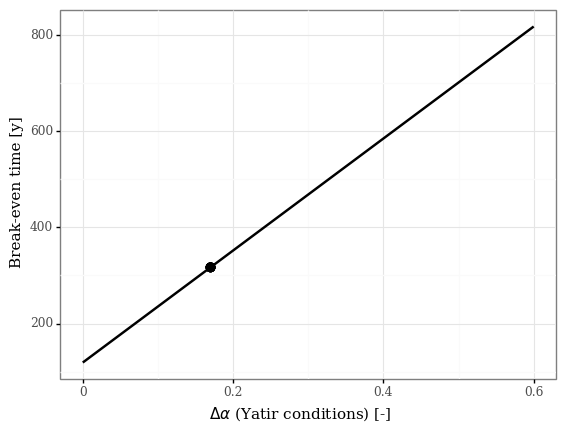

<ggplot: (-9223371893994603132)>


In [12]:
from plotnine import *

# Plot
plt = ggplot(df)
plt = plt + geom_line(aes(x='delta_albedo', y='y'), size=1)
plt = plt + geom_point(x=0.17, y=316.9, size=3)
plt = plt + labs(x='$\Delta α$ (Yatir conditions) [-]', y='Break-even time [y]', parse=True)
plt = plt + theme_bw()
plt = plt + theme(text=element_text(family="serif"))
print(plt)

In [13]:
carbon_suppression_lst = ['Coal', 'Gas', 'World']
insolation_lst = list(np.arange(100, 300, 50))
pve_lst = [0.01, 0.05, 0.10, 0.20]

# Create a df where we have a PV installation, and the albedo changes for 3 scenarios
index = pd.MultiIndex.from_product([carbon_suppression_lst, insolation_lst, pve_lst], names = ['Scenario', 'insolation', 'pve'])
df = pd.DataFrame(index = index).reset_index()

# Add delta albedo
df['delta_albedo'] = delta_alb_ketura

# Amount of CO2 emitted by each kWh generated by different energy sources
df['FCO2'] = np.nan
df.loc[df['Scenario'] == 'Coal', 'FCO2']  = FCO2_coal
df.loc[df['Scenario'] == 'Gas', 'FCO2']   = FCO2_gas
df.loc[df['Scenario'] == 'World', 'FCO2'] = FCO2_world

# Add carbon emission suppression or sequestration
df['C_emiss_seq'] = calculate_CES(EP_a, df['FCO2'], LCA)

# RF_t
df['RF_t'] = 0

# Now fill with calculations
df['RFr_global'], df['RF_pve'], df['RFr_local'], df['delta_C'], df['C_atm'], df['nu_etminan'], df['RF_C'], df['y'] = \
    calculate_breakeven_time_df(df['delta_albedo'], df['PVeff'], df['insolation'], df['C_emiss_seq'], df['RF_t'])

display(df)

Scenario  insolation   pve  delta_albedo  FCO2  C_emiss_seq  RF_t  \
0      Coal         100  0.01          0.11  0.87    30.595909     0   
1      Coal         100  0.05          0.11  0.87    30.595909     0   
2      Coal         100  0.10          0.11  0.87    30.595909     0   
3      Coal         100  0.20          0.11  0.87    30.595909     0   
4      Coal         150  0.01          0.11  0.87    30.595909     0   
5      Coal         150  0.05          0.11  0.87    30.595909     0   
6      Coal         150  0.10          0.11  0.87    30.595909     0   
7      Coal         150  0.20          0.11  0.87    30.595909     0   
8      Coal         200  0.01          0.11  0.87    30.595909     0   
9      Coal         200  0.05          0.11  0.87    30.595909     0   
10     Coal         200  0.10          0.11  0.87    30.595909     0   
11     Coal         200  0.20          0.11  0.87    30.595909     0   
12     Coal         250  0.01          0.11  0.87    30.595909     0   
13     Coal         250  0.05          0.11  0.87    30.595909     0   
14     Coal         250  0.10          0.11  0.87    30.595909     0   
15     Coal         250  0.20          0.11  0.87    30.595909     0   
16      Gas         100  0.01          0.11  0.40    13.291364     0   
17      Gas         100  0.05          0.11  0.40    13.291364     0   
18      Gas         100  0.10          0.11  0.40    13.291364     0   
19      Gas         100  0.20          0.11  0.40    13.291364     0   
20      Gas         150  0.01          0.11  0.40    13.291364     0   
21      Gas         150  0.05          0.11  0.40    13.291364     0   
22      Gas         150  0.10          0.11  0.40    13.291364     0   
23      Gas         150  0.20          0.11  0.40    13.291364     0   
24      Gas         200  0.01          0.11  0.40    13.291364     0   
25      Gas         200  0.05          0.11  0.40    13.291364     0   
26      Gas         200  0.10          0.11  0.40    13.291364     0   
27      Gas         200  0.20          0.11  0.40    13.291364     0   
28      Gas         250  0.01          0.11  0.40    13.291364     0   
29      Gas         250  0.05          0.11  0.40    13.291364     0   
30      Gas         250  0.10          0.11  0.40    13.291364     0   
31      Gas         250  0.20          0.11  0.40    13.291364     0   
32    World         100  0.01          0.11  0.54    18.445909     0   
33    World         100  0.05          0.11  0.54    18.445909     0   
34    World         100  0.10          0.11  0.54    18.445909     0   
35    World         100  0.20          0.11  0.54    18.445909     0   
36    World         150  0.01          0.11  0.54    18.445909     0   
37    World         150  0.05          0.11  0.54    18.445909     0   
38    World         150  0.10          0.11  0.54    18.445909     0   
39    World         150  0.20          0.11  0.54    18.445909     0   
40    World         200  0.01          0.11  0.54    18.445909     0   
41    World         200  0.05          0.11  0.54    18.445909     0   
42    World         200  0.10          0.11  0.54    18.445909     0   
43    World         200  0.20          0.11  0.54    18.445909     0   
44    World         250  0.01          0.11  0.54    18.445909     0   
45    World         250  0.05          0.11  0.54    18.445909     0   
46    World         250  0.10          0.11  0.54    18.445909     0   
47    World         250  0.20          0.11  0.54    18.445909     0   

      RFr_global        RF_pve  RFr_local       delta_C   C_atm  nu_etminan  \
0   2.156863e-14  1.960784e-15       11.0  6.515795e-12  409.85     5.29049   
1   2.156863e-14  9.803922e-15       11.0  6.515795e-12  409.85     5.29049   
2   2.156863e-14  1.960784e-14       11.0  6.515795e-12  409.85     5.29049   
3   2.156863e-14  3.921569e-14       11.0  6.515795e-12  409.85     5.29049   
4   3.235294e-14  2.941176e-15       16.5  6.515795e-12  409.85     5.29049   


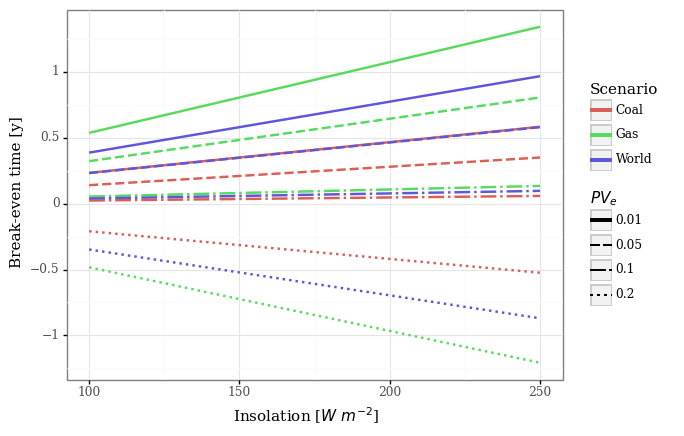

<ggplot: (-9223371969884240152)>


In [14]:
from plotnine import *

df['pve'] = df['pve'].astype('category')

# Plot
plt = ggplot(df)
plt = plt + geom_line(aes(x='insolation', y='y', color='Scenario', linetype='pve'), size=1)
plt = plt + labs(x='Insolation [$W~m^{-2}$]', y='Break-even time [y]', linetype='$PV_e$', parse=True)
plt = plt + theme_bw()
plt = plt + theme(text=element_text(family="serif"))
print(plt)

## Expanding to a world-wide PV installation
- Requires knowledge of PV field installations in different places

### IMPORTANT THINGS TO CONSIDER
- Seasonality of albedo due to vegetation
- Can we get soil albedo when replacing a forest with a PV field?

In [15]:
# Based on latitude & longitude, obtain:
# - the expected angle of the panels (affects albedo)
# - the spacing of the panels (affects % soil, shade & panels of the field, i.e. affects albedo)
def get_PV_installation_attributes(lat, lon):
    spacing = 1
    angle   = 1
    percent_panels = 1
    return(1)

# Obtain the albedo of the field based on:
# - percentage of panels on a field
# - albedo of the soil
# - spacing and angle of a PV installation
# - insolation (required for shade albedo)
# - albedo of the soil
# - date & time (to calculate the shade fraction)
def get_PV_albedo_attributes(percent_panels, spacing, angle, insolation, albedo_soil, datetime):
    
    albedo_panels = spacing + angle # TODO: define this calculation
    
    percent_soil = datetime + angle + spacing # TODO: define this calculation
    
    albedo_shade = albedo_soil + insolation # TODO: calculation based on 'reduction in light due to shade'
    percent_shade = 100 - percent_panels - percent_soil
    
    albedo_field = percent_panels * albedo_panels + percent_soil * albedo_soil + percent_shade * albedo_shade
    return(albedo_field)

# Based on percentage of panels on a field and the insolation, obtain:
# - the electrical output [kWh]
# - the expected PVe
def get_PV_efficiency_attributes(percent_panels, insolation):
    output = 1
    PVe = 1
    return(1)

### Run the code

In [16]:
# Constants
lat = 1
lon = 1

In [17]:
# Based on latitude & longitude, obtain:
# - the expected angle of the panels (affects albedo)
# - the spacing of the panels (affects % soil, shade & panels of the field, i.e. affects albedo)
angle_pv, spacing_pv, percent_panels = get_PV_installation_attributes(lat, lon)

# Based on percentage of panels on a field and the insolation, obtain:
# - the electrical output [kWh]
# - the expected PVe
pve = get_PV_efficiency_attributes(percent_panels, insolation)

albedo_pv_field = get_PV_albedo_attributes(percent_panels, spacing, angle, insolation, albedo_soil, datetime)

TypeError: cannot unpack non-iterable int object